In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms.functional as TF
from torchvision import transforms
%matplotlib inline

In [2]:
r50_swav_200ep = torch.hub.load('yukimasano/PASS:main', 'swav_resnet50')


Using cache found in /home/srvargh2/.cache/torch/hub/yukimasano_PASS_main


_IncompatibleKeys(missing_keys=[], unexpected_keys=['projection_head.0.weight', 'projection_head.0.bias', 'projection_head.1.weight', 'projection_head.1.bias', 'projection_head.1.running_mean', 'projection_head.1.running_var', 'projection_head.1.num_batches_tracked', 'projection_head.3.weight', 'projection_head.3.bias', 'prototypes.weight'])


In [3]:
device = torch.device('cuda:0')
r50_swav_200ep.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
tensor = torch.randn(2,3,250,250)

#r50_swav_200ep.fc[0]=nn.Linear(2058 , 2)

model = nn.Sequential(r50_swav_200ep,nn.Linear(2048 , 2))

tensor=tensor.to(device)
model.to(device)
out=model(tensor)

In [5]:
print(out.shape)
print(out)

torch.Size([2, 2])
tensor([[-0.0084, -0.0633],
        [-0.0042, -0.0292]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [2]:
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Resize((250,250)),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.RandomAdjustSharpness(sharpness_factor=0.5,p=0.25),
                                          torchvision.transforms.RandomAdjustSharpness(sharpness_factor=1.25,p=0.25),
                                          torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.25),
                                          torchvision.transforms.RandomPerspective(),
                                          torchvision.transforms.RandomResizedCrop(size=(250,250)),
                                          
                                         ])
train_dataset=torchvision.datasets.ImageFolder("dataset2/train",transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=True)


<PIL.Image.Image image mode=RGB size=250x250 at 0x2B7EC9C2E6A0>


Text(0.5, 1.0, 'tensor([1])')

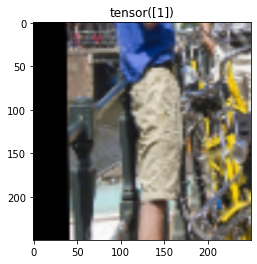

In [7]:
iter_data=iter(train_loader)
x,y=iter_data.next()
#check Image
x_img=transforms.ToPILImage()(x[0]).convert("RGB")
print(x_img)
plt.imshow(np.asarray(x_img))
plt.title(y)
#0 is no people 1 is with people

In [8]:
import torch.optim as optim
#net=model
net2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)
#net= nn.Sequential(r50_swav_200ep,nn.Linear(2048 , 2048),nn.Linear(2048 , 2048),nn.Linear(2048 , 2))

net= nn.Sequential(net2,nn.Linear(1000 , 64),nn.Linear(64 , 64),nn.Linear(64 , 2))
net.to(device)
class_weights=torch.FloatTensor([1, 1]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

Using cache found in /home/srvargh2/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
def test_acc(net,testloader,device):
    correct = 0
    total = 0
    tp=0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            
            # the class with the highest prob is what we choose as prediction
            #print(outputs.shape)
            predicted = torch.argmax(outputs,dim=1,keepdim=False)
            #print(predicted.shape)
            total += labels.size(0)
            
            #print(labels.shape)
            #print(predicted.shape)
            #print(predicted.to(device) == labels.to(device))
            correct += (predicted.to(device) == labels.to(device)).sum()
            p_lables= 1 == labels.to(device)
            tp+=(predicted.to(device) == p_lables.to(device)).sum()
            

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    print(f'number of true positives of the network on the test images: {tp}')
    return int(100 * correct // total)

In [10]:
train_dataset=torchvision.datasets.ImageFolder("dataset2/train",transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)

#need actualy testing data
test_dataset=torchvision.datasets.ImageFolder("dataset2/test",transform=transform)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

best_test_acc=0

scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,400)

for epoch in range(20):  # loop over the dataset multiple times

    
    with torch.set_grad_enabled(True):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()

            # print statistics
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                #test_acc(net,testloader,device)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0
                
                with torch.set_grad_enabled(False):
                    temp_acc=test_acc(net,test_loader,device)
                    if temp_acc > best_test_acc:
                        torch.save(net.state_dict(), f"models/test_acc_{temp_acc}_v101_v2.pth")
                        best_test_acc=temp_acc
            
print('Finished Training')

[1,    20] loss: 0.798


/scratch/311722/ipykernel_9586/631579588.py:26: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  print(f'Accuracy of the network on the test images: {100 * correct // total} %')
/scratch/311722/ipykernel_9586/631579588.py:28: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return int(100 * correct // total)


Accuracy of the network on the test images: 46 %
number of true positives of the network on the test images: 540
[1,    40] loss: 0.751
Accuracy of the network on the test images: 50 %
number of true positives of the network on the test images: 586
[1,    60] loss: 0.709
Accuracy of the network on the test images: 54 %
number of true positives of the network on the test images: 633
[1,    80] loss: 0.679
Accuracy of the network on the test images: 55 %
number of true positives of the network on the test images: 640
[1,   100] loss: 0.635
Accuracy of the network on the test images: 57 %
number of true positives of the network on the test images: 671
[1,   120] loss: 0.614
Accuracy of the network on the test images: 61 %
number of true positives of the network on the test images: 713
[1,   140] loss: 0.601
Accuracy of the network on the test images: 63 %
number of true positives of the network on the test images: 737
[1,   160] loss: 0.564
Accuracy of the network on the test images: 64 %

[3,   360] loss: 0.252
Accuracy of the network on the test images: 86 %
number of true positives of the network on the test images: 999
[3,   380] loss: 0.258
Accuracy of the network on the test images: 86 %
number of true positives of the network on the test images: 1007
[3,   400] loss: 0.255
Accuracy of the network on the test images: 85 %
number of true positives of the network on the test images: 992
[3,   420] loss: 0.263
Accuracy of the network on the test images: 86 %
number of true positives of the network on the test images: 1007
[3,   440] loss: 0.260
Accuracy of the network on the test images: 86 %
number of true positives of the network on the test images: 1001
[4,    20] loss: 0.239
Accuracy of the network on the test images: 86 %
number of true positives of the network on the test images: 1004
[4,    40] loss: 0.246
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1022
[4,    60] loss: 0.250
Accuracy of the netw

[6,   240] loss: 0.174
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1037
[6,   260] loss: 0.170
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1022
[6,   280] loss: 0.170
Accuracy of the network on the test images: 87 %
number of true positives of the network on the test images: 1020
[6,   300] loss: 0.170
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1036
[6,   320] loss: 0.183
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1022
[6,   340] loss: 0.169
Accuracy of the network on the test images: 87 %
number of true positives of the network on the test images: 1018
[6,   360] loss: 0.181
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1031
[6,   380] loss: 0.188
Accuracy of the ne

[9,   120] loss: 0.149
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1052
[9,   140] loss: 0.138
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1028
[9,   160] loss: 0.144
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1040
[9,   180] loss: 0.127
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1037
[9,   200] loss: 0.154
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1050
[9,   220] loss: 0.144
Accuracy of the network on the test images: 88 %
number of true positives of the network on the test images: 1027
[9,   240] loss: 0.147
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1049
[9,   260] loss: 0.134
Accuracy of the ne

[11,   440] loss: 0.137
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1057
[12,    20] loss: 0.121
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1045
[12,    40] loss: 0.111
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1047
[12,    60] loss: 0.130
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1056
[12,    80] loss: 0.117
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1049
[12,   100] loss: 0.118
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1047
[12,   120] loss: 0.137
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1047
[12,   140] loss: 0.123
Accuracy o

[14,   320] loss: 0.121
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1057
[14,   340] loss: 0.117
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1046
[14,   360] loss: 0.127
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1064
[14,   380] loss: 0.112
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1038
[14,   400] loss: 0.108
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1040
[14,   420] loss: 0.117
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1054
[14,   440] loss: 0.105
Accuracy of the network on the test images: 89 %
number of true positives of the network on the test images: 1038
[15,    20] loss: 0.111
Accuracy o

[17,   200] loss: 0.106
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1058
[17,   220] loss: 0.126
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1064
[17,   240] loss: 0.113
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1051
[17,   260] loss: 0.115
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1058
[17,   280] loss: 0.107
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1058
[17,   300] loss: 0.121
Accuracy of the network on the test images: 92 %
number of true positives of the network on the test images: 1069
[17,   320] loss: 0.111
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1053
[17,   340] loss: 0.128
Accuracy o

[20,    80] loss: 0.092
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1062
[20,   100] loss: 0.099
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1056
[20,   120] loss: 0.100
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1051
[20,   140] loss: 0.119
Accuracy of the network on the test images: 90 %
number of true positives of the network on the test images: 1053
[20,   160] loss: 0.108
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1064
[20,   180] loss: 0.108
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1062
[20,   200] loss: 0.102
Accuracy of the network on the test images: 91 %
number of true positives of the network on the test images: 1065
[20,   220] loss: 0.101
Accuracy o

In [11]:
#save model
torch.save(net.state_dict(), "models/v101_Pass_model_tune_v2.pth")

Using cache found in /home/srvargh2/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([2, 3, 250, 250])
torch.Size([2])
model predicted 1


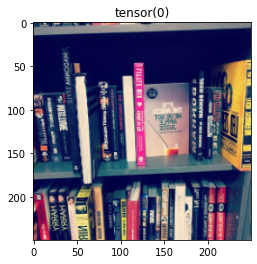

In [3]:
with torch.no_grad():
    #need actualy testing data
    test_dataset=torchvision.datasets.ImageFolder("dataset2/test",transform=transform)
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=2,shuffle=True)


    device = torch.device('cuda:0')
    #redifine model
    net2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)
    #net= nn.Sequential(r50_swav_200ep,nn.Linear(2048 , 2048),nn.Linear(2048 , 2048),nn.Linear(2048 , 2))

    net= nn.Sequential(net2,nn.Linear(1000 , 64),nn.Linear(64 , 64),nn.Linear(64 , 2))
    net.to(device)

    net.load_state_dict(torch.load("models/test_acc_92_v101_v2.pth"))

    iter_data=iter(test_loader)
    x,y=iter_data.next()
    print(x.shape)
    print(y.shape)


    #check Image
    x_img=transforms.ToPILImage()(x[0]).convert("RGB")
    #print(x_img)
    plt.imshow(np.asarray(x_img))
    plt.title(y[0])


    #prediction from model
    pred = net(x.to(device))
    #print(pred)
    print("model predicted {}".format(torch.argmax(pred,dim=1)[0]))
    #0 is no people 1 is with people

model predicted 1


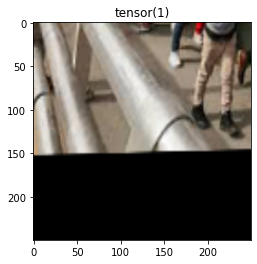

In [40]:
with torch.no_grad():
    iter_data=iter(test_loader)
    x,y=iter_data.next()
    #print(x.shape)
    #print(y.shape)


    #check Image
    x_img=transforms.ToPILImage()(x[0]).convert("RGB")
    #print(x_img)
    plt.imshow(np.asarray(x_img))
    plt.title(y[0])


    #prediction from model
    pred = net(x.to(device))
    #print(pred)
    print("model predicted {}".format(torch.argmax(pred,dim=1)[0]))
    #0 is no people 1 is with people